<a href="https://colab.research.google.com/github/Kadomium/Car_kit/blob/main/Car_kit_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell, Dropout

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [22]:
%pip install japanize-matplotlib
import japanize_matplotlib

In [23]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
#ここをサンプルのcdnoに
df = pd.read_csv('/content/drive/MyDrive/Car-kit/carkit_100%.csv')
#df_10 = pd.read_csv('/content/drive/MyDrive/Car-kit/carkit_edit.csv')
#df_raw = df_10.copy()
df.head()

,key,qstrend,qxq999,qqkey,qs3,qxxx_1,qsk4_15,qsk4_1c,qsk4_2c,qs4_3,...,q57_117,q57_118,q57_2,q63,qxxx_10,qw3,qw7,qw11,qw5p,qw6
0,137000005,98,0.99600,6dcfd7121267effc8ba8a603233a6eace21ce331,2,NaN,1897,38,12,8,...,0,0,2,2,NaN,15,5,9400093,14,1
1,137000009,98,1.28326,2803263b7bbf69327e59981693d27af750dc7453,1,NaN,664,4,4,8,...,0,0,1,1,NaN,34,8,7310138,1,3
2,137000007,98,0.78118,c20af19f0e25d4cb7d2b9140930f1ae666315d61,3,NaN,1897,38,12,8,...,0,0,2,3,NaN,23,6,4410105,7,4
3,137000008,98,0.77699,3dfe5f849b7f9faa14c08dc1b48117745658d56d,1,NaN,227,1,1,5,...,0,0,1,3,NaN,14,4,2450063,13,3
4,137000010,98,0.65201,534a18a3770249dcaf5f358152648665217ef264,1,NaN,169,1,1,4,...,0,0,1,3,NaN,14,4,2470002,13,3


In [5]:
# とりあえずnullが1%以上の列は明らかに不要だから消しちゃう(df_cleaned)
# 後々0.4以上にして欠損値補完をするのもいい(プランB)
nan_ratio = df.isnull().sum() / len(df)
cols_to_drop = nan_ratio[nan_ratio > 0.01].index

df_cleaned = df.drop(columns=cols_to_drop)
#2回目の洗浄、列指定でデータリークやIDを消していく

all_columns_to_drop = ['key', 'qqkey', 'qxq999','qs3','qsk4_1c','qsk4_2c','qs4_3','qs4_8a','qs4_9','qs4_10','qs4_11','qs4_12','qs4_13','qsq4_gas','qskei_1','qskei_2','qsnou_1','qsnou_2','qsq2','q6_2','q6_4','q6_5_31','q6_5_32','q6_5_33','q6_5_34','q6_5_35','q6_5_36','q6_5_37','q6_5_38','q6_5_39','q6_5_310','q6_5_311','q6_5_312','q6_5_313','q6_5_314','q6_5_315','q6_5_316','q6_5_317','q6_5_318','q6_5_319','q6_5_320','q6_5_321','q6_5_41','q6_5_42','q6_5_43','q6_5_44','q6_5_45','q6_5_46','q6_5_47','q6_5_48','q6_5_49','q6_5_410','q6_5_411','q6_5_412','q6_5_413','q6_5_414','q6_5_415','q6_5_416','q6_5_417','q6_5_418','q6_5_419','q6_5_420','q6_5_421','q6_5_51','q6_5_52','q6_5_53','q6_5_54','q6_5_55','q6_5_56','q6_5_57','q6_5_58','q6_5_59','q6_5_510','q6_5_511','q6_5_512','q6_5_513','q6_5_514','q6_5_515','q6_5_516','q6_5_517','q6_5_518','q6_5_519','q6_5_520','q6_5_521','q6_5_61','q6_5_62','q6_5_63','q6_5_64','q6_5_65','q6_5_66','q6_5_67','q6_5_68','q6_5_69','q6_5_610','q6_5_611','q6_5_612','q6_5_613','q6_5_614','q6_5_615','q6_5_616','q6_5_617','q6_5_618','q6_5_619','q6_5_620','q6_5_621','q9_2','q12_2','q13_11','q13_12','q13_13','q13_14','q13_15','q13_16','q13_17','q13_18','q13_19','q13_110','q13_111','q13_112','q13_113','q13_114','q13_115','q13_116','q13_117','q13_118','q13_119','q13_120','q13_121','q13_122','q13_123','q13_124','q13_125','q13_126','q13_127','q13_128','q13_2','q14_2','qsq22_1','q29_2','q34_2','q57_2','q63','qw11']

df_cleaned = df_cleaned.drop(columns=all_columns_to_drop)

In [6]:
#qsk4_15=426がN-BOX、428がN-BOX Custom
# qsk4_15が428なら1、そうでなければ0の列を作成

df_cleaned['target_count_custom'] = (df_cleaned['qsk4_15'] == 428).astype(int)

# ★★★★★ このタイミングで 'qsk4_15' を完全に削除する ★★★★★
df_cleaned.drop(columns=['qsk4_15'], inplace=True)

In [7]:
# 1. 各列のnullの数を計算
nan_counts = df_cleaned.isnull().sum()
# 2. nullの数を降順でソートして表示
print("--- 各列のNullの数（降順） ---")
print(nan_counts.sort_values(ascending=False))

# 3. データ総数に対するnullの割合を計算して表示
total_rows = len(df_cleaned)
nan_ratio = (df_cleaned.isnull().sum() / total_rows) * 100
print("\n--- 各列のNullの割合（%） ---")
print(nan_ratio.sort_values(ascending=False))

--- 各列のNullの数（降順） ---
q57_17     0
q57_16     0
q57_15     0
q57_14     0
q57_13     0
          ..
qs8        0
qs7_2      0
qs7        0
qs4_4a     0
qstrend    0
Length: 896, dtype: int64

--- 各列のNullの割合（%） ---
q57_17     0.0
q57_16     0.0
q57_15     0.0
q57_14     0.0
q57_13     0.0
          ... 
qs8        0.0
qs7_2      0.0
qs7        0.0
qs4_4a     0.0
qstrend    0.0
Length: 896, dtype: float64


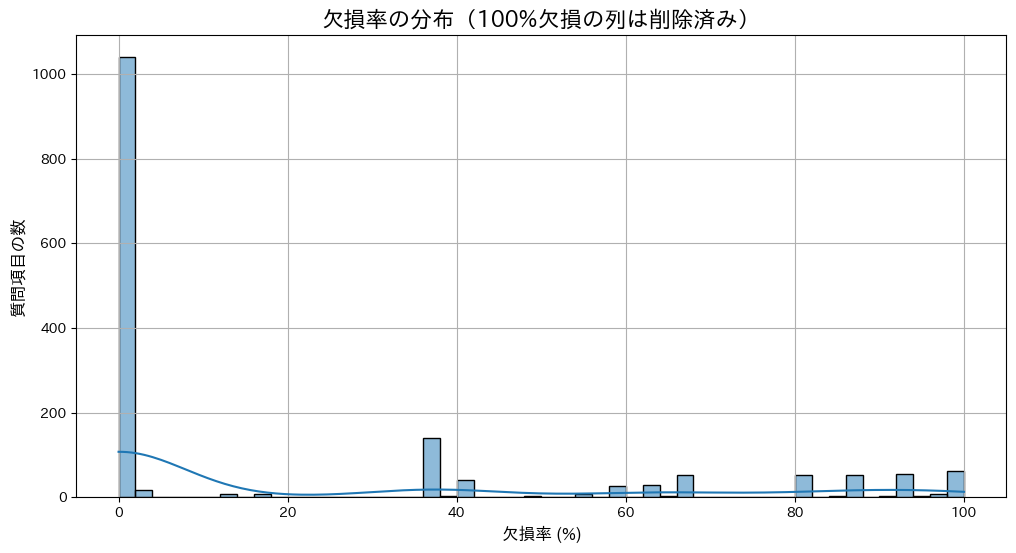

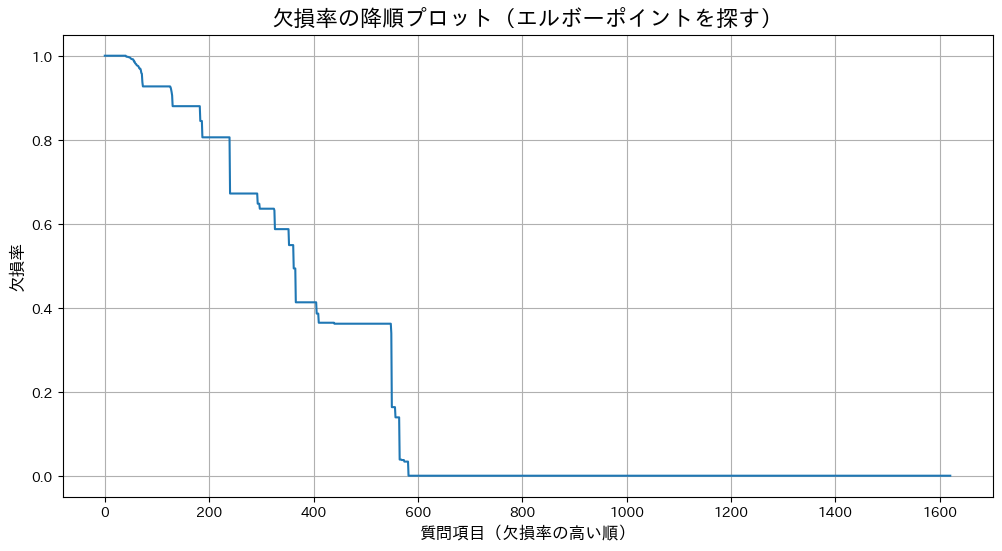

In [8]:
# 残った列で再度、欠損率を計算
nan_ratio = df.isnull().sum() / len(df)

# 可視化1: ヒストグラムで欠損率の分布を見る
plt.figure(figsize=(12, 6))
sns.histplot(nan_ratio * 100, bins=50, kde=True)
plt.title('欠損率の分布（100%欠損の列は削除済み）', fontsize=16)
plt.xlabel('欠損率 (%)', fontsize=12)
plt.ylabel('質問項目の数', fontsize=12)
plt.grid(True)
plt.savefig("null_hist.png", dpi=300, bbox_inches='tight')
plt.show()

# 可視化2: 欠損率を降順にソートした棒グラフで見る
plt.figure(figsize=(12, 6))
nan_ratio.sort_values(ascending=False).plot(kind='line', use_index=False)
plt.title('欠損率の降順プロット（エルボーポイントを探す）', fontsize=16)
plt.xlabel('質問項目（欠損率の高い順）', fontsize=12)
plt.ylabel('欠損率', fontsize=12)
plt.grid(True)
plt.savefig("null_elbow.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# --- Step 1: 時間コードと実際の年月を対応付ける辞書を作成 ---
# このマッピングを37ヶ月分作成します
start_year = 2021
start_month = 12
time_map = {}
for i in range(37):
    current_year = start_year + (start_month + i - 1) // 12
    current_month = (start_month + i - 1) % 12 + 1

    time_code = 102 + i
    date_str = f"{current_year}-{current_month:02d}" # '2022-01' のように0埋めする

    time_map[time_code] = date_str

# --- Step 2: 辞書を使って 'qs4_4a'列を置換（マッピング） ---
# .map()メソッドを使うのが最も簡単で効率的です
df_cleaned['date_str'] = df_cleaned['qs4_4a'].map(time_map)

# --- Step 3: 【最重要】文字列をPandasのdatetime型（月末実績値）に変換 ---
df_cleaned['date'] = pd.to_datetime(df_cleaned['date_str']).dt.to_period('M').dt.to_timestamp('M')

# --- Step 4: datetime型の列をデータフレームのインデックスに設定 ---
# これにより、データが正式に時系列データとして扱われます
df_cleaned.set_index('date', inplace=True)

# 元の不要になった列は削除して整理
df_cleaned.drop(['qs4_4a', 'date_str'], axis=1, inplace=True)

print("\n--- 最終的な時系列データフレーム ---")
print(df_cleaned.head())
print("\nインデックスの型:")
print(type(df_cleaned.index))


--- 最終的な時系列データフレーム ---
            qstrend  qs7  qs7_2  qs8  qs8_2  qs9  qs18  qs19  q9_11  q9_12  \
date                                                                         
2021-12-31       98    1      3    1      1    1     1    61      0      0   
2021-12-31       98    1      1    1      1    1     1    38      1      0   
2021-12-31       98    3      1    1      1    1     2    46      0      0   
2021-12-31       98    3      3    1      1    1     2    30      0      0   
2021-12-31       98    3      2    1      1    1     2    47      0      0   

            ...  q57_114  q57_115  q57_116  q57_117  q57_118  qw3  qw7  qw5p  \
date        ...                                                                
2021-12-31  ...        0        0        0        0        0   15    5    14   
2021-12-31  ...        0        0        0        0        0   34    8     1   
2021-12-31  ...        0        0        0        0        0   23    6     7   
2021-12-31  ...        0     

In [10]:
# Step 1の分類に基づき、集計戦略を立てる
# まず、4.多クラスのカテゴリデータ(職業、最も運転する人など)をOne-Hotエンコーディングする
df_cleaned = pd.get_dummies(df_cleaned, columns=['qs9','q13_2a','q47','qw3','qw7','qw5p'])

# Step 2: .agg() を使って一気に集計する
# 集計ルールを辞書で定義
#1. 連続する数値データ(年齢)　は : 'mean', 外れ値が嫌なら : 'median',
#2. 段階的な数値データ(満足度、こだわり度) : 'mean',
#3. バイナリデータは : 'mean',


aggregation_rules = {
    'qs7': 'mean', # 購入関与に段階あり
    'qs7_2': 'mean', # 運転者の頻度で段階あり
    'qs8': 'mean', # 商用、自家用で段階あり
    'qs8_2': 'mean', # 最頻運転車の段階数値1or2
    'qs18': 'mean', # 性別1or2
    'qs19': 'mean', # メインドライバーの年齢（大体正規化する）
    'q9_11': 'mean', # 購入時期の理由バイナリ
    'q9_12': 'mean', # 購入時期の理由バイナリ
    'q9_13': 'mean', # 購入時期の理由バイナリ
    'q9_14': 'mean', # 購入時期の理由バイナリ
    'q9_15': 'mean', # 購入時期の理由バイナリ
    'q9_16': 'mean', # 購入時期の理由バイナリ
    'q9_17': 'mean', # 購入時期の理由バイナリ
    'q9_18': 'mean', # 購入時期の理由バイナリ
    'q9_19': 'mean', # 購入時期の理由バイナリ
    'q9_110': 'mean', # 購入時期の理由バイナリ
    'q9_111': 'mean', # 購入時期の理由バイナリ
    'q9_112': 'mean', # 購入時期の理由バイナリ
    'q9_113': 'mean', # 購入時期の理由バイナリ
    'q9_114': 'mean', # 購入時期の理由バイナリ
    'q9_115': 'mean', # 購入時期の理由バイナリ
    'q9_116': 'mean', # 購入時期の理由バイナリ
    'q9_117': 'mean', # 購入時期の理由バイナリ
    'q9_118': 'mean', # 購入時期の理由バイナリ
    'q9_119': 'mean', # 購入時期の理由バイナリ
    'q9_120': 'mean', # 購入時期の理由バイナリ
    'q9_121': 'mean', # 購入時期の理由バイナリ
    'q9_122': 'mean', # 購入時期の理由バイナリ
    'q9_123': 'mean', # 購入時期の理由バイナリ
    'q9_124': 'mean', # 購入時期の理由バイナリ
    'q9_125': 'mean', # 購入時期の理由バイナリ
    'q9_126': 'mean', # 購入時期の理由バイナリ
    'q9_127': 'mean', # 購入時期の理由バイナリ
    'q9_128': 'mean', # 購入時期の理由バイナリ
    'q9_129': 'mean', # 購入時期の理由バイナリ
    'q9_130': 'mean', # 購入時期の理由バイナリ
    'q9_131': 'mean', # 購入時期の理由バイナリ
    'q9_132': 'mean', # 購入時期の理由バイナリ
    'q101': 'mean', # 購入きっかけバイナリ
    'q102': 'mean', # 購入きっかけバイナリ
    'q103': 'mean', # 購入きっかけバイナリ
    'q104': 'mean', # 購入きっかけバイナリ
    'q105': 'mean', # 購入きっかけバイナリ
    'q106': 'mean', # 購入きっかけバイナリ
    'q107': 'mean', # 購入きっかけバイナリ
    'q108': 'mean', # 購入きっかけバイナリ
    'q109': 'mean', # 購入きっかけバイナリ
    'q1010': 'mean', # 購入きっかけバイナリ
    'q1011': 'mean', # 購入きっかけバイナリ
    'q1012': 'mean', # 購入きっかけバイナリ
    'q1013': 'mean', # 購入きっかけバイナリ
    'q1014': 'mean', # 購入きっかけバイナリ
    'q1015': 'mean', # 購入きっかけバイナリ
    'q1016': 'mean', # 購入きっかけバイナリ
    'q1017': 'mean', # 購入きっかけバイナリ
    'q1018': 'mean', # 購入きっかけバイナリ
    'q1019': 'mean', # 購入きっかけバイナリ
    'q1020': 'mean', # 購入きっかけバイナリ
    'q1021': 'mean', # 購入きっかけバイナリ
    'q1022': 'mean', # 購入きっかけバイナリ
    'q1023': 'mean', # 購入きっかけバイナリ
    'q1024': 'mean', # 購入きっかけバイナリ
    'q1025': 'mean', # 購入きっかけバイナリ
    'q1026': 'mean', # 購入きっかけバイナリ
    'q1027': 'mean', # 購入きっかけバイナリ
    'q1028': 'mean', # 購入きっかけバイナリ
    'q1029': 'mean', # 購入きっかけバイナリ
    'q1030': 'mean', # 購入きっかけバイナリ
    'q1031': 'mean', # 購入きっかけバイナリ
    'q1032': 'mean', # 購入きっかけバイナリ
    'q12_11': 'mean', # 購入前提条件バイナリ
    'q12_12': 'mean', # 購入前提条件バイナリ
    'q12_13': 'mean', # 購入前提条件バイナリ
    'q12_14': 'mean', # 購入前提条件バイナリ
    'q12_15': 'mean', # 購入前提条件バイナリ
    'q12_16': 'mean', # 購入前提条件バイナリ
    'q12_17': 'mean', # 購入前提条件バイナリ
    'q12_18': 'mean', # 購入前提条件バイナリ
    'q12_19': 'mean', # 購入前提条件バイナリ
    'q12_110': 'mean', # 購入前提条件バイナリ
    'q12_111': 'mean', # 購入前提条件バイナリ
    'q12_112': 'mean', # 購入前提条件バイナリ
    'q12_113': 'mean', # 購入前提条件バイナリ
    'q12_114': 'mean', # 購入前提条件バイナリ
    'q12_115': 'mean', # 購入前提条件バイナリ
    'q12_116': 'mean', # 購入前提条件バイナリ
    'q12_117': 'mean', # 購入前提条件バイナリ
    'q12_118': 'mean', # 購入前提条件バイナリ
    'q12_119': 'mean', # 購入前提条件バイナリ
    'q12_120': 'mean', # 購入前提条件バイナリ
    'q12_121': 'mean', # 購入前提条件バイナリ
    'q12_122': 'mean', # 購入前提条件バイナリ
    'q12_123': 'mean', # 購入前提条件バイナリ
    'q12_124': 'mean', # 購入前提条件バイナリ
    'q12_125': 'mean', # 購入前提条件バイナリ
    'q12_126': 'mean', # 購入前提条件バイナリ
    'q12_127': 'mean', # 購入前提条件バイナリ
    'q12_128': 'mean', # 購入前提条件バイナリ
    'q12_129': 'mean', # 購入前提条件バイナリ
    'q12_130': 'mean', # 購入前提条件バイナリ
    'q12_131': 'mean', # 購入前提条件バイナリ
    'q12_132': 'mean', # 購入前提条件バイナリ
    'q12_133': 'mean', # 購入前提条件バイナリ
    'q12_134': 'mean', # 購入前提条件バイナリ
    'q12_135': 'mean', # 購入前提条件バイナリ
    'q12_136': 'mean', # 購入前提条件バイナリ
    'q13_3': 'mean', # こだわり度は段階的な数値データ
    'q14_11': 'mean', # ボディタイプ選択理由バイナリ
    'q14_12': 'mean', # ボディタイプ選択理由バイナリ
    'q14_13': 'mean', # ボディタイプ選択理由バイナリ
    'q14_14': 'mean', # ボディタイプ選択理由バイナリ
    'q14_15': 'mean', # ボディタイプ選択理由バイナリ
    'q14_16': 'mean', # ボディタイプ選択理由バイナリ
    'q14_17': 'mean', # ボディタイプ選択理由バイナリ
    'q14_18': 'mean', # ボディタイプ選択理由バイナリ
    'q14_19': 'mean', # ボディタイプ選択理由バイナリ
    'q14_110': 'mean', # ボディタイプ選択理由バイナリ
    'q14_111': 'mean', # ボディタイプ選択理由バイナリ
    'q14_112': 'mean', # ボディタイプ選択理由バイナリ
    'q14_113': 'mean', # ボディタイプ選択理由バイナリ
    'q14_114': 'mean', # ボディタイプ選択理由バイナリ
    'q14_115': 'mean', # ボディタイプ選択理由バイナリ
    'q14_116': 'mean', # ボディタイプ選択理由バイナリ
    'q14_117': 'mean', # ボディタイプ選択理由バイナリ
    'q14_118': 'mean', # ボディタイプ選択理由バイナリ
    'q14_119': 'mean', # ボディタイプ選択理由バイナリ
    'q14_120': 'mean', # ボディタイプ選択理由バイナリ
    'q14_121': 'mean', # ボディタイプ選択理由バイナリ
    'q14_122': 'mean', # ボディタイプ選択理由バイナリ
    'q191': 'mean', # 車種イメージバイナリ
    'q192': 'mean', # 車種イメージバイナリ
    'q193': 'mean', # 車種イメージバイナリ
    'q194': 'mean', # 車種イメージバイナリ
    'q195': 'mean', # 車種イメージバイナリ
    'q196': 'mean', # 車種イメージバイナリ
    'q197': 'mean', # 車種イメージバイナリ
    'q198': 'mean', # 車種イメージバイナリ
    'q199': 'mean', # 車種イメージバイナリ
    'q1910': 'mean', # 車種イメージバイナリ
    'q1911': 'mean', # 車種イメージバイナリ
    'q1912': 'mean', # 車種イメージバイナリ
    'q1913': 'mean', # 車種イメージバイナリ
    'q1914': 'mean', # 車種イメージバイナリ
    'q1915': 'mean', # 車種イメージバイナリ
    'q1916': 'mean', # 車種イメージバイナリ
    'q1917': 'mean', # 車種イメージバイナリ
    'q1918': 'mean', # 車種イメージバイナリ
    'q1919': 'mean', # 車種イメージバイナリ
    'q1920': 'mean', # 車種イメージバイナリ
    'q1921': 'mean', # 車種イメージバイナリ
    'q1922': 'mean', # 車種イメージバイナリ
    'q1923': 'mean', # 車種イメージバイナリ
    'q1924': 'mean', # 車種イメージバイナリ
    'q1925': 'mean', # 車種イメージバイナリ
    'q1926': 'mean', # 車種イメージバイナリ
    'q1927': 'mean', # 車種イメージバイナリ
    'q1928': 'mean', # 車種イメージバイナリ
    'q1929': 'mean', # 車種イメージバイナリ
    'q1930': 'mean', # 車種イメージバイナリ
    'q1931': 'mean', # 車種イメージバイナリ
    'q1932': 'mean', # 車種イメージバイナリ
    'q1933': 'mean', # 車種イメージバイナリ
    'q201': 'mean', # 購入時重視項目バイナリ
    'q202': 'mean', # 購入時重視項目バイナリ
    'q203': 'mean', # 購入時重視項目バイナリ
    'q204': 'mean', # 購入時重視項目バイナリ
    'q205': 'mean', # 購入時重視項目バイナリ
    'q206': 'mean', # 購入時重視項目バイナリ
    'q207': 'mean', # 購入時重視項目バイナリ
    'q208': 'mean', # 購入時重視項目バイナリ
    'q209': 'mean', # 購入時重視項目バイナリ
    'q2010': 'mean', # 購入時重視項目バイナリ
    'q2011': 'mean', # 購入時重視項目バイナリ
    'q2012': 'mean', # 購入時重視項目バイナリ
    'q2013': 'mean', # 購入時重視項目バイナリ
    'q2014': 'mean', # 購入時重視項目バイナリ
    'q2015': 'mean', # 購入時重視項目バイナリ
    'q2016': 'mean', # 購入時重視項目バイナリ
    'q2017': 'mean', # 購入時重視項目バイナリ
    'q2018': 'mean', # 購入時重視項目バイナリ
    'q2019': 'mean', # 購入時重視項目バイナリ
    'q2020': 'mean', # 購入時重視項目バイナリ
    'q2021': 'mean', # 購入時重視項目バイナリ
    'q2022': 'mean', # 購入時重視項目バイナリ
    'q2023': 'mean', # 購入時重視項目バイナリ
    'q2024': 'mean', # 購入時重視項目バイナリ
    'q2025': 'mean', # 購入時重視項目バイナリ
    'q2026': 'mean', # 購入時重視項目バイナリ
    'q2027': 'mean', # 購入時重視項目バイナリ
    'q2028': 'mean', # 購入時重視項目バイナリ
    'q2029': 'mean', # 購入時重視項目バイナリ
    'q2030': 'mean', # 購入時重視項目バイナリ
    'q2031': 'mean', # 購入時重視項目バイナリ
    'q2032': 'mean', # 購入時重視項目バイナリ
    'q2033': 'mean', # 購入時重視項目バイナリ
    'q2034': 'mean', # 購入時重視項目バイナリ
    'q2035': 'mean', # 購入時重視項目バイナリ
    'q2036': 'mean', # 購入時重視項目バイナリ
    'q2037': 'mean', # 購入時重視項目バイナリ
    'q2038': 'mean', # 購入時重視項目バイナリ
    'q2039': 'mean', # 購入時重視項目バイナリ
    'q2040': 'mean', # 購入時重視項目バイナリ
    'q2041': 'mean', # 購入時重視項目バイナリ
    'q2042': 'mean', # 購入時重視項目バイナリ
    'q2043': 'mean', # 購入時重視項目バイナリ
    'q2044': 'mean', # 購入時重視項目バイナリ
    'q2045': 'mean', # 購入時重視項目バイナリ
    'q2046': 'mean', # 購入時重視項目バイナリ
    'q2047': 'mean', # 購入時重視項目バイナリ
    'q2048': 'mean', # 購入時重視項目バイナリ
    'q2049': 'mean', # 購入時重視項目バイナリ
    'q2050': 'mean', # 購入時重視項目バイナリ
    'q2051': 'mean', # 購入時重視項目バイナリ
    'q2052': 'mean', # 購入時重視項目バイナリ
    'q2053': 'mean', # 購入時重視項目バイナリ
    'q2054': 'mean', # 購入時重視項目バイナリ
    'q2055': 'mean', # 購入時重視項目バイナリ
    'q2056': 'mean', # 購入時重視項目バイナリ
    'q20_21': 'mean', # 購入時検討行動バイナリ
    'q20_22': 'mean', # 購入時検討行動バイナリ
    'q20_23': 'mean', # 購入時検討行動バイナリ
    'q20_24': 'mean', # 購入時検討行動バイナリ
    'q20_25': 'mean', # 購入時検討行動バイナリ
    'q20_26': 'mean', # 購入時検討行動バイナリ
    'q20_27': 'mean', # 購入時検討行動バイナリ
    'q20_28': 'mean', # 購入時検討行動バイナリ
    'q21': 'mean', # 1or2で比較検討車種の有無
    'q221': 'mean', #比較検討車種バイナリ
    'q222': 'mean', #比較検討車種バイナリ
    'q223': 'mean', #比較検討車種バイナリ
    'q224': 'mean', #比較検討車種バイナリ
    'q225': 'mean', #比較検討車種バイナリ
    'q226': 'mean', #比較検討車種バイナリ
    'q227': 'mean', #比較検討車種バイナリ
    'q228': 'mean', #比較検討車種バイナリ
    'q229': 'mean', #比較検討車種バイナリ
    'q2210': 'mean', #比較検討車種バイナリ
    'q2211': 'mean', #比較検討車種バイナリ
    'q2212': 'mean', #比較検討車種バイナリ
    'q2213': 'mean', #比較検討車種バイナリ
    'q2214': 'mean', #比較検討車種バイナリ
    'q2215': 'mean', #比較検討車種バイナリ
    'q2216': 'mean', #比較検討車種バイナリ
    'q2217': 'mean', #比較検討車種バイナリ
    'q2218': 'mean', #比較検討車種バイナリ
    'q2219': 'mean', #比較検討車種バイナリ
    'q2220': 'mean', #比較検討車種バイナリ
    'q2221': 'mean', #比較検討車種バイナリ
    'q2222': 'mean', #比較検討車種バイナリ
    'q2223': 'mean', #比較検討車種バイナリ
    'q2224': 'mean', #比較検討車種バイナリ
    'q2225': 'mean', #比較検討車種バイナリ
    'q2226': 'mean', #比較検討車種バイナリ
    'q2227': 'mean', #比較検討車種バイナリ
    'q2228': 'mean', #比較検討車種バイナリ
    'q2229': 'mean', #比較検討車種バイナリ
    'q2230': 'mean', #比較検討車種バイナリ
    'q2231': 'mean', #比較検討車種バイナリ
    'q2232': 'mean', #比較検討車種バイナリ
    'q2233': 'mean', #比較検討車種バイナリ
    'q2234': 'mean', #比較検討車種バイナリ
    'q2235': 'mean', #比較検討車種バイナリ
    'q2236': 'mean', #比較検討車種バイナリ
    'q2237': 'mean', #比較検討車種バイナリ
    'q2238': 'mean', #比較検討車種バイナリ
    'q2239': 'mean', #比較検討車種バイナリ
    'q2240': 'mean', #比較検討車種バイナリ
    'q2241': 'mean', #比較検討車種バイナリ
    'q2242': 'mean', #比較検討車種バイナリ
    'q2243': 'mean', #比較検討車種バイナリ
    'q2244': 'mean', #比較検討車種バイナリ
    'q2245': 'mean', #比較検討車種バイナリ
    'q2246': 'mean', #比較検討車種バイナリ
    'q2247': 'mean', #比較検討車種バイナリ
    'q2248': 'mean', #比較検討車種バイナリ
    'q2249': 'mean', #比較検討車種バイナリ
    'q2250': 'mean', #比較検討車種バイナリ
    'q2251': 'mean', #比較検討車種バイナリ
    'q2252': 'mean', #比較検討車種バイナリ
    'q2253': 'mean', #比較検討車種バイナリ
    'q2254': 'mean', #比較検討車種バイナリ
    'q2255': 'mean', #比較検討車種バイナリ
    'q2256': 'mean', #比較検討車種バイナリ
    'q2257': 'mean', #比較検討車種バイナリ
    'q2258': 'mean', #比較検討車種バイナリ
    'q2259': 'mean', #比較検討車種バイナリ
    'q2260': 'mean', #比較検討車種バイナリ
    'q2261': 'mean', #比較検討車種バイナリ
    'q2262': 'mean', #比較検討車種バイナリ
    'q2263': 'mean', #比較検討車種バイナリ
    'q2264': 'mean', #比較検討車種バイナリ
    'q2265': 'mean', #比較検討車種バイナリ
    'q2266': 'mean', #比較検討車種バイナリ
    'q2267': 'mean', #比較検討車種バイナリ
    'q2268': 'mean', #比較検討車種バイナリ
    'q2269': 'mean', #比較検討車種バイナリ
    'q2270': 'mean', #比較検討車種バイナリ
    'q2271': 'mean', #比較検討車種バイナリ
    'q2272': 'mean', #比較検討車種バイナリ
    'q2273': 'mean', #比較検討車種バイナリ
    'q2274': 'mean', #比較検討車種バイナリ
    'q2275': 'mean', #比較検討車種バイナリ
    'q2276': 'mean', #比較検討車種バイナリ
    'q2277': 'mean', #比較検討車種バイナリ
    'q2278': 'mean', #比較検討車種バイナリ
    'q2279': 'mean', #比較検討車種バイナリ
    'q2280': 'mean', #比較検討車種バイナリ
    'q2281': 'mean', #比較検討車種バイナリ
    'q2282': 'mean', #比較検討車種バイナリ
    'q2283': 'mean', #比較検討車種バイナリ
    'q2284': 'mean', #比較検討車種バイナリ
    'q2285': 'mean', #比較検討車種バイナリ
    'q2286': 'mean', #比較検討車種バイナリ
    'q2287': 'mean', #比較検討車種バイナリ
    'q2288': 'mean', #比較検討車種バイナリ
    'q2289': 'mean', #比較検討車種バイナリ
    'q2290': 'mean', #比較検討車種バイナリ
    'q2291': 'mean', #比較検討車種バイナリ
    'q2292': 'mean', #比較検討車種バイナリ
    'q2293': 'mean', #比較検討車種バイナリ
    'q2294': 'mean', #比較検討車種バイナリ
    'q2295': 'mean', #比較検討車種バイナリ
    'q2296': 'mean', #比較検討車種バイナリ
    'q2297': 'mean', #比較検討車種バイナリ
    'q2298': 'mean', #比較検討車種バイナリ
    'q2299': 'mean', #比較検討車種バイナリ
    'q22100': 'mean', #比較検討車種バイナリ
    'q22101': 'mean', #比較検討車種バイナリ
    'q22102': 'mean', #比較検討車種バイナリ
    'q22103': 'mean', #比較検討車種バイナリ
    'q22104': 'mean', #比較検討車種バイナリ
    'q22105': 'mean', #比較検討車種バイナリ
    'q22106': 'mean', #比較検討車種バイナリ
    'q22107': 'mean', #比較検討車種バイナリ
    'q22108': 'mean', #比較検討車種バイナリ
    'q22109': 'mean', #比較検討車種バイナリ
    'q22110': 'mean', #比較検討車種バイナリ
    'q22111': 'mean', #比較検討車種バイナリ
    'q22112': 'mean', #比較検討車種バイナリ
    'q22113': 'mean', #比較検討車種バイナリ
    'q22114': 'mean', #比較検討車種バイナリ
    'q22115': 'mean', #比較検討車種バイナリ
    'q22116': 'mean', #比較検討車種バイナリ
    'q22117': 'mean', #比較検討車種バイナリ
    'q22118': 'mean', #比較検討車種バイナリ
    'q22119': 'mean', #比較検討車種バイナリ
    'q22120': 'mean', #比較検討車種バイナリ
    'q22121': 'mean', #比較検討車種バイナリ
    'q22122': 'mean', #比較検討車種バイナリ
    'q22123': 'mean', #比較検討車種バイナリ
    'q22124': 'mean', #比較検討車種バイナリ
    'q22125': 'mean', #比較検討車種バイナリ
    'q22126': 'mean', #比較検討車種バイナリ
    'q22127': 'mean', #比較検討車種バイナリ
    'q22128': 'mean', #比較検討車種バイナリ
    'q22129': 'mean', #比較検討車種バイナリ
    'q22130': 'mean', #比較検討車種バイナリ
    'q22131': 'mean', #比較検討車種バイナリ
    'q22132': 'mean', #比較検討車種バイナリ
    'q22133': 'mean', #比較検討車種バイナリ
    'q22134': 'mean', #比較検討車種バイナリ
    'q22135': 'mean', #比較検討車種バイナリ
    'q22136': 'mean', #比較検討車種バイナリ
    'q22137': 'mean', #比較検討車種バイナリ
    'q22138': 'mean', #比較検討車種バイナリ
    'q22139': 'mean', #比較検討車種バイナリ
    'q22140': 'mean', #比較検討車種バイナリ
    'q22141': 'mean', #比較検討車種バイナリ
    'q22142': 'mean', #比較検討車種バイナリ
    'q22143': 'mean', #比較検討車種バイナリ
    'q22144': 'mean', #比較検討車種バイナリ
    'q22145': 'mean', #比較検討車種バイナリ
    'q22146': 'mean', #比較検討車種バイナリ
    'q22147': 'mean', #比較検討車種バイナリ
    'q22148': 'mean', #比較検討車種バイナリ
    'q22149': 'mean', #比較検討車種バイナリ
    'q22150': 'mean', #比較検討車種バイナリ
    'q22151': 'mean', #比較検討車種バイナリ
    'q22152': 'mean', #比較検討車種バイナリ
    'q22153': 'mean', #比較検討車種バイナリ
    'q22154': 'mean', #比較検討車種バイナリ
    'q22155': 'mean', #比較検討車種バイナリ
    'q22156': 'mean', #比較検討車種バイナリ
    'q22157': 'mean', #比較検討車種バイナリ
    'q22158': 'mean', #比較検討車種バイナリ
    'q22159': 'mean', #比較検討車種バイナリ
    'q22160': 'mean', #比較検討車種バイナリ
    'q22161': 'mean', #比較検討車種バイナリ
    'q22162': 'mean', #比較検討車種バイナリ
    'q22163': 'mean', #比較検討車種バイナリ
    'q22164': 'mean', #比較検討車種バイナリ
    'q22165': 'mean', #比較検討車種バイナリ
    'q22166': 'mean', #比較検討車種バイナリ
    'q22167': 'mean', #比較検討車種バイナリ
    'q22168': 'mean', #比較検討車種バイナリ
    'q22169': 'mean', #比較検討車種バイナリ
    'q22170': 'mean', #比較検討車種バイナリ
    'q22171': 'mean', #比較検討車種バイナリ
    'q22172': 'mean', #比較検討車種バイナリ
    'q22173': 'mean', #比較検討車種バイナリ
    'q22174': 'mean', #比較検討車種バイナリ
    'q22175': 'mean', #比較検討車種バイナリ
    'q22176': 'mean', #比較検討車種バイナリ
    'q22177': 'mean', #比較検討車種バイナリ
    'q22178': 'mean', #比較検討車種バイナリ
    'q22179': 'mean', #比較検討車種バイナリ
    'q22180': 'mean', #比較検討車種バイナリ
    'q22181': 'mean', #比較検討車種バイナリ
    'q22182': 'mean', #比較検討車種バイナリ
    'q22183': 'mean', #比較検討車種バイナリ
    'q22184': 'mean', #比較検討車種バイナリ
    'q22185': 'mean', #比較検討車種バイナリ
    'q22186': 'mean', #比較検討車種バイナリ
    'q22187': 'mean', #比較検討車種バイナリ
    'q22188': 'mean', #比較検討車種バイナリ
    'q22189': 'mean', #比較検討車種バイナリ
    'q22190': 'mean', #比較検討車種バイナリ
    'q22191': 'mean', #比較検討車種バイナリ
    'q22192': 'mean', #比較検討車種バイナリ
    'q22193': 'mean', #比較検討車種バイナリ
    'q22194': 'mean', #比較検討車種バイナリ
    'q22195': 'mean', #比較検討車種バイナリ
    'q22196': 'mean', #比較検討車種バイナリ
    'q22197': 'mean', #比較検討車種バイナリ
    'q22198': 'mean', #比較検討車種バイナリ
    'q22199': 'mean', #比較検討車種バイナリ
    'q22200': 'mean', #比較検討車種バイナリ
    'q22201': 'mean', #比較検討車種バイナリ
    'q22202': 'mean', #比較検討車種バイナリ
    'q22203': 'mean', #比較検討車種バイナリ
    'q22204': 'mean', #比較検討車種バイナリ
    'q22205': 'mean', #比較検討車種バイナリ
    'q22206': 'mean', #比較検討車種バイナリ
    'q22207': 'mean', #比較検討車種バイナリ
    'q22208': 'mean', #比較検討車種バイナリ
    'q22209': 'mean', #比較検討車種バイナリ
    'q22210': 'mean', #比較検討車種バイナリ
    'q22211': 'mean', #比較検討車種バイナリ
    'q22212': 'mean', #比較検討車種バイナリ
    'q22213': 'mean', #比較検討車種バイナリ
    'q22214': 'mean', #比較検討車種バイナリ
    'q22215': 'mean', #比較検討車種バイナリ
    'q22216': 'mean', #比較検討車種バイナリ
    'q22217': 'mean', #比較検討車種バイナリ
    'q22218': 'mean', #比較検討車種バイナリ
    'q22219': 'mean', #比較検討車種バイナリ
    'q22220': 'mean', #比較検討車種バイナリ
    'q22221': 'mean', #比較検討車種バイナリ
    'q22222': 'mean', #比較検討車種バイナリ
    'q22223': 'mean', #比較検討車種バイナリ
    'q22224': 'mean', #比較検討車種バイナリ
    'q22225': 'mean', #比較検討車種バイナリ
    'q22226': 'mean', #比較検討車種バイナリ
    'q22227': 'mean', #比較検討車種バイナリ
    'q22228': 'mean', #比較検討車種バイナリ
    'q22229': 'mean', #比較検討車種バイナリ
    'q22230': 'mean', #比較検討車種バイナリ
    'q22231': 'mean', #比較検討車種バイナリ
    'q22232': 'mean', #比較検討車種バイナリ
    'q22233': 'mean', #比較検討車種バイナリ
    'q22234': 'mean', #比較検討車種バイナリ
    'q22235': 'mean', #比較検討車種バイナリ
    'q22236': 'mean', #比較検討車種バイナリ
    'q22237': 'mean', #比較検討車種バイナリ
    'q22238': 'mean', #比較検討車種バイナリ
    'q22239': 'mean', #比較検討車種バイナリ
    'q22240': 'mean', #比較検討車種バイナリ
    'q22241': 'mean', #比較検討車種バイナリ
    'q22242': 'mean', #比較検討車種バイナリ
    'q22243': 'mean', #比較検討車種バイナリ
    'q22244': 'mean', #比較検討車種バイナリ
    'q22245': 'mean', #比較検討車種バイナリ
    'q22246': 'mean', #比較検討車種バイナリ
    'q22247': 'mean', #比較検討車種バイナリ
    'q22248': 'mean', #比較検討車種バイナリ
    'q22249': 'mean', #比較検討車種バイナリ
    'q22250': 'mean', #比較検討車種バイナリ
    'q22251': 'mean', #比較検討車種バイナリ
    'q22252': 'mean', #比較検討車種バイナリ
    'q22253': 'mean', #比較検討車種バイナリ
    'q22254': 'mean', #比較検討車種バイナリ
    'q22255': 'mean', #比較検討車種バイナリ
    'q22256': 'mean', #比較検討車種バイナリ
    'q22257': 'mean', #比較検討車種バイナリ
    'q22258': 'mean', #比較検討車種バイナリ
    'q22259': 'mean', #比較検討車種バイナリ
    'q22260': 'mean', #比較検討車種バイナリ
    'q22261': 'mean', #比較検討車種バイナリ
    'q22262': 'mean', #比較検討車種バイナリ
    'q22263': 'mean', #比較検討車種バイナリ
    'q22264': 'mean', #比較検討車種バイナリ
    'q22265': 'mean', #比較検討車種バイナリ
    'q22266': 'mean', #比較検討車種バイナリ
    'q22267': 'mean', #比較検討車種バイナリ
    'q22268': 'mean', #比較検討車種バイナリ
    'q22269': 'mean', #比較検討車種バイナリ
    'q22270': 'mean', #比較検討車種バイナリ
    'q22271': 'mean', #比較検討車種バイナリ
    'q22272': 'mean', #比較検討車種バイナリ
    'q22273': 'mean', #比較検討車種バイナリ
    'q22274': 'mean', #比較検討車種バイナリ
    'q22275': 'mean', #比較検討車種バイナリ
    'q22276': 'mean', #比較検討車種バイナリ
    'q22277': 'mean', #比較検討車種バイナリ
    'q22278': 'mean', #比較検討車種バイナリ
    'q22279': 'mean', #比較検討車種バイナリ
    'q22280': 'mean', #比較検討車種バイナリ
    'q22281': 'mean', #比較検討車種バイナリ
    'q22282': 'mean', #比較検討車種バイナリ
    'q22283': 'mean', #比較検討車種バイナリ
    'q22284': 'mean', #比較検討車種バイナリ
    'q22285': 'mean', #比較検討車種バイナリ
    'q22286': 'mean', #比較検討車種バイナリ
    'q22287': 'mean', #比較検討車種バイナリ
    'q22288': 'mean', #比較検討車種バイナリ
    'q22289': 'mean', #比較検討車種バイナリ
    'q22290': 'mean', #比較検討車種バイナリ
    'q22291': 'mean', #比較検討車種バイナリ
    'q22292': 'mean', #比較検討車種バイナリ
    'q22293': 'mean', #比較検討車種バイナリ
    'q22294': 'mean', #比較検討車種バイナリ
    'q22295': 'mean', #比較検討車種バイナリ
    'q22296': 'mean', #比較検討車種バイナリ
    'q22297': 'mean', #比較検討車種バイナリ
    'q22298': 'mean', #比較検討車種バイナリ
    'q22299': 'mean', #比較検討車種バイナリ
    'q22300': 'mean', #比較検討車種バイナリ
    'q22301': 'mean', #比較検討車種バイナリ
    'q22302': 'mean', #比較検討車種バイナリ
    'q22303': 'mean', #比較検討車種バイナリ
    'q22304': 'mean', #比較検討車種バイナリ
    'q22305': 'mean', #比較検討車種バイナリ
    'q22306': 'mean', #比較検討車種バイナリ
    'q22307': 'mean', #比較検討車種バイナリ
    'q22308': 'mean', #比較検討車種バイナリ
    'q22309': 'mean', #比較検討車種バイナリ
    'q22310': 'mean', #比較検討車種バイナリ
    'q22311': 'mean', #比較検討車種バイナリ
    'q22312': 'mean', #比較検討車種バイナリ
    'q22313': 'mean', #比較検討車種バイナリ
    'q22314': 'mean', #比較検討車種バイナリ
    'q22315': 'mean', #比較検討車種バイナリ
    'q22316': 'mean', #比較検討車種バイナリ
    'q22317': 'mean', #比較検討車種バイナリ
    'q22318': 'mean', #比較検討車種バイナリ
    'q22319': 'mean', #比較検討車種バイナリ
    'q22320': 'mean', #比較検討車種バイナリ
    'q22321': 'mean', #比較検討車種バイナリ
    'q22322': 'mean', #比較検討車種バイナリ
    'q22323': 'mean', #比較検討車種バイナリ
    'q22324': 'mean', #比較検討車種バイナリ
    'q22325': 'mean', #比較検討車種バイナリ
    'q22326': 'mean', #比較検討車種バイナリ
    'q22327': 'mean', #比較検討車種バイナリ
    'q22328': 'mean', #比較検討車種バイナリ
    'q22329': 'mean', #比較検討車種バイナリ
    'q22330': 'mean', #比較検討車種バイナリ
    'q22331': 'mean', #比較検討車種バイナリ
    'q22332': 'mean', #比較検討車種バイナリ
    'q22333': 'mean', #比較検討車種バイナリ
    'q22334': 'mean', #比較検討車種バイナリ
    'q22335': 'mean', #比較検討車種バイナリ
    'q22336': 'mean', #比較検討車種バイナリ
    'q22337': 'mean', #比較検討車種バイナリ
    'q22338': 'mean', #比較検討車種バイナリ
    'q22339': 'mean', #比較検討車種バイナリ
    'q22340': 'mean', #比較検討車種バイナリ
    'q22341': 'mean', #比較検討車種バイナリ
    'q22342': 'mean', #比較検討車種バイナリ
    'q22343': 'mean', #比較検討車種バイナリ
    'q22344': 'mean', #比較検討車種バイナリ
    'q22345': 'mean', #比較検討車種バイナリ
    'q22346': 'mean', #比較検討車種バイナリ
    'q22347': 'mean', #比較検討車種バイナリ
    'q22348': 'mean', #比較検討車種バイナリ
    'q22349': 'mean', #比較検討車種バイナリ
    'q22350': 'mean', #比較検討車種バイナリ
    'q22351': 'mean', #比較検討車種バイナリ
    'q22352': 'mean', #比較検討車種バイナリ
    'q22353': 'mean', #比較検討車種バイナリ
    'q22354': 'mean', #比較検討車種バイナリ
    'q22355': 'mean', #比較検討車種バイナリ
    'q22356': 'mean', #比較検討車種バイナリ
    'q22357': 'mean', #比較検討車種バイナリ
    'q22358': 'mean', #比較検討車種バイナリ
    'q22359': 'mean', #比較検討車種バイナリ
    'q22360': 'mean', #比較検討車種バイナリ
    'q22361': 'mean', #比較検討車種バイナリ
    'q22362': 'mean', #比較検討車種バイナリ
    'q22363': 'mean', #比較検討車種バイナリ
    'q22364': 'mean', #比較検討車種バイナリ
    'q22365': 'mean', #比較検討車種バイナリ
    'q22366': 'mean', #比較検討車種バイナリ
    'q22367': 'mean', #比較検討車種バイナリ
    'q22368': 'mean', #比較検討車種バイナリ
    'q22369': 'mean', #比較検討車種バイナリ
    'q22370': 'mean', #比較検討車種バイナリ
    'q22371': 'mean', #比較検討車種バイナリ
    'q22372': 'mean', #比較検討車種バイナリ
    'q22373': 'mean', #比較検討車種バイナリ
    'q22374': 'mean', #比較検討車種バイナリ
    'q22375': 'mean', #比較検討車種バイナリ
    'q22376': 'mean', #比較検討車種バイナリ
    'q22377': 'mean', #比較検討車種バイナリ
    'q22378': 'mean', #比較検討車種バイナリ
    'q22379': 'mean', #比較検討車種バイナリ
    'q22380': 'mean', #比較検討車種バイナリ
    'q22381': 'mean', #比較検討車種バイナリ
    'q22382': 'mean', #比較検討車種バイナリ
    'q22383': 'mean', #比較検討車種バイナリ
    'q22384': 'mean', #比較検討車種バイナリ
    'q22385': 'mean', #比較検討車種バイナリ
    'q22386': 'mean', #比較検討車種バイナリ
    'q28_11': 'mean', #購入関与者バイナリ
    'q28_12': 'mean', #購入関与者バイナリ
    'q28_13': 'mean', #購入関与者バイナリ
    'q28_14': 'mean', #購入関与者バイナリ
    'q28_15': 'mean', #購入関与者バイナリ
    'q28_16': 'mean', #購入関与者バイナリ
    'q28_17': 'mean', #購入関与者バイナリ
    'q28_18': 'mean', #購入関与者バイナリ
    'q28_19': 'mean', #購入関与者バイナリ
    'q28_110': 'mean', #購入関与者バイナリ
    'q28_111': 'mean', #購入関与者バイナリ
    'q28_21': 'mean', #資金提供者バイナリ
    'q28_22': 'mean', #資金提供者バイナリ
    'q28_23': 'mean', #資金提供者バイナリ
    'q28_24': 'mean', #資金提供者バイナリ
    'q28_25': 'mean', #資金提供者バイナリ
    'q28_26': 'mean', #資金提供者バイナリ
    'q28_27': 'mean', #資金提供者バイナリ
    'q28_28': 'mean', #資金提供者バイナリ
    'q28_29': 'mean', #資金提供者バイナリ
    'q28_210': 'mean', #資金提供者バイナリ
    'q28_211': 'mean', #資金提供者バイナリ
    'q29_11': 'mean', #運転者バイナリ
    'q29_12': 'mean', #運転者バイナリ
    'q29_13': 'mean', #運転者バイナリ
    'q29_14': 'mean', #運転者バイナリ
    'q29_15': 'mean', #運転者バイナリ
    'q29_16': 'mean', #運転者バイナリ
    'q29_17': 'mean', #運転者バイナリ
    'q29_18': 'mean', #運転者バイナリ
    'q29_19': 'mean', #運転者バイナリ
    'q29_110': 'mean', #運転者バイナリ
    'q29_111': 'mean', #運転者バイナリ
    'q30': 'mean', #最頻運転者性別1or2
    'q31': 'mean', #最頻運転者年齢連続データ
    'q32': 'mean', #最頻運転者未既婚1or2
    'q331': 'mean', #最頻運転者子供年代段階データ
    'q332': 'mean', #最頻運転者子供年代段階データ
    'q333': 'mean', #最頻運転者子供年代段階データ
    'q334': 'mean', #最頻運転者子供年代段階データ
    'q335': 'mean', #最頻運転者子供年代段階データ
    'q336': 'mean', #最頻運転者子供年代段階データ
    'q337': 'mean', #最頻運転者子供年代段階データ
    'q338': 'mean', #最頻運転者子供年代段階データ
    'q339': 'mean', #最頻運転者子供年代段階データ
    'q34_11': 'mean', #想定使用用途バイナリ
    'q34_12': 'mean', #想定使用用途バイナリ
    'q34_13': 'mean', #想定使用用途バイナリ
    'q34_14': 'mean', #想定使用用途バイナリ
    'q34_15': 'mean', #想定使用用途バイナリ
    'q34_16': 'mean', #想定使用用途バイナリ
    'q34_17': 'mean', #想定使用用途バイナリ
    'q34_18': 'mean', #想定使用用途バイナリ
    'q34_19': 'mean', #想定使用用途バイナリ
    'q34_110': 'mean', #想定使用用途バイナリ
    'q34_111': 'mean', #想定使用用途バイナリ
    'q34_112': 'mean', #最頻使用用途バイナリ
    'q34_113': 'mean', #最頻使用用途バイナリ
    'q34_114': 'mean', #最頻使用用途バイナリ
    'q34_115': 'mean', #最頻使用用途バイナリ
    'q34_116': 'mean', #最頻使用用途バイナリ
    'q34_117': 'mean', #最頻使用用途バイナリ
    'q34_118': 'mean', #最頻使用用途バイナリ
    'q34_119': 'mean', #最頻使用用途バイナリ
    'q34_120': 'mean', #最頻使用用途バイナリ
    'q34_121': 'mean', #最頻使用用途バイナリ
    'q34_122': 'mean', #最頻使用用途バイナリ
    'q34_31': 'mean', #店舗選択重視点バイナリ
    'q34_32': 'mean', #店舗選択重視点バイナリ
    'q34_33': 'mean', #店舗選択重視点バイナリ
    'q34_34': 'mean', #店舗選択重視点バイナリ
    'q34_35': 'mean', #店舗選択重視点バイナリ
    'q34_36': 'mean', #店舗選択重視点バイナリ
    'q34_37': 'mean', #店舗選択重視点バイナリ
    'q34_38': 'mean', #店舗選択重視点バイナリ
    'q34_39': 'mean', #店舗選択重視点バイナリ
    'q34_310': 'mean', #店舗選択重視点バイナリ
    'q34_311': 'mean', #店舗選択重視点バイナリ
    'q34_312': 'mean', #最頻店舗選択重視点バイナリ
    'q34_313': 'mean', #最頻店舗選択重視点バイナリ
    'q34_314': 'mean', #最頻店舗選択重視点バイナリ
    'q34_315': 'mean', #最頻店舗選択重視点バイナリ
    'q34_316': 'mean', #最頻店舗選択重視点バイナリ
    'q36': 'mean', #保有台数連続数値データ
    'q411': 'mean', #メーカーイメージバイナリ
    'q412': 'mean', #メーカーイメージバイナリ
    'q413': 'mean', #メーカーイメージバイナリ
    'q414': 'mean', #メーカーイメージバイナリ
    'q415': 'mean', #メーカーイメージバイナリ
    'q416': 'mean', #メーカーイメージバイナリ
    'q417': 'mean', #メーカーイメージバイナリ
    'q418': 'mean', #メーカーイメージバイナリ
    'q419': 'mean', #メーカーイメージバイナリ
    'q4110': 'mean', #メーカーイメージバイナリ
    'q4111': 'mean', #メーカーイメージバイナリ
    'q4112': 'mean', #メーカーイメージバイナリ
    'q4113': 'mean', #メーカーイメージバイナリ
    'q4114': 'mean', #メーカーイメージバイナリ
    'q4115': 'mean', #メーカーイメージバイナリ
    'q4116': 'mean', #メーカーイメージバイナリ
    'q4117': 'mean', #メーカーイメージバイナリ
    'q4118': 'mean', #メーカーイメージバイナリ
    'q4119': 'mean', #メーカーイメージバイナリ
    'q4120': 'mean', #メーカーイメージバイナリ
    'q4121': 'mean', #メーカーイメージバイナリ
    'q4122': 'mean', #メーカーイメージバイナリ
    'q4123': 'mean', #メーカーイメージバイナリ
    'q4124': 'mean', #メーカーイメージバイナリ
    'q4125': 'mean', #メーカーイメージバイナリ
    'q4126': 'mean', #メーカーイメージバイナリ
    'q4127': 'mean', #メーカーイメージバイナリ
    'qsq42_11': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_12': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_13': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_14': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_15': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_16': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_17': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_18': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_19': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_110': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_111': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_112': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_113': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_114': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_115': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_116': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_117': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_118': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_119': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_120': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_121': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_122': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_123': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_124': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_125': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_126': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_127': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_128': 'mean', #買ったことあるメーカーバイナリ
    'qsq42_21': 'mean', #持っているメーカーバイナリ
    'qsq42_22': 'mean', #持っているメーカーバイナリ
    'qsq42_23': 'mean', #持っているメーカーバイナリ
    'qsq42_24': 'mean', #持っているメーカーバイナリ
    'qsq42_25': 'mean', #持っているメーカーバイナリ
    'qsq42_26': 'mean', #持っているメーカーバイナリ
    'qsq42_27': 'mean', #持っているメーカーバイナリ
    'qsq42_28': 'mean', #持っているメーカーバイナリ
    'qsq42_29': 'mean', #持っているメーカーバイナリ
    'qsq42_210': 'mean', #持っているメーカーバイナリ
    'qsq42_211': 'mean', #持っているメーカーバイナリ
    'qsq42_212': 'mean', #持っているメーカーバイナリ
    'qsq42_213': 'mean', #持っているメーカーバイナリ
    'qsq42_214': 'mean', #持っているメーカーバイナリ
    'qsq42_215': 'mean', #持っているメーカーバイナリ
    'qsq42_216': 'mean', #持っているメーカーバイナリ
    'qsq42_217': 'mean', #持っているメーカーバイナリ
    'qsq42_218': 'mean', #持っているメーカーバイナリ
    'qsq42_219': 'mean', #持っているメーカーバイナリ
    'qsq42_220': 'mean', #持っているメーカーバイナリ
    'qsq42_221': 'mean', #持っているメーカーバイナリ
    'qsq42_222': 'mean', #持っているメーカーバイナリ
    'qsq42_223': 'mean', #持っているメーカーバイナリ
    'qsq42_224': 'mean', #持っているメーカーバイナリ
    'qsq42_225': 'mean', #持っているメーカーバイナリ
    'qsq42_226': 'mean', #持っているメーカーバイナリ
    'qsq42_227': 'mean', #持っているメーカーバイナリ
    'qsq42_228': 'mean', #持っているメーカーバイナリ
    'q42_31': 'mean', #好きなメーカーバイナリ
    'q42_32': 'mean', #好きなメーカーバイナリ
    'q42_33': 'mean', #好きなメーカーバイナリ
    'q42_34': 'mean', #好きなメーカーバイナリ
    'q42_35': 'mean', #好きなメーカーバイナリ
    'q42_36': 'mean', #好きなメーカーバイナリ
    'q42_37': 'mean', #好きなメーカーバイナリ
    'q42_38': 'mean', #好きなメーカーバイナリ
    'q42_39': 'mean', #好きなメーカーバイナリ
    'q42_310': 'mean', #好きなメーカーバイナリ
    'q42_311': 'mean', #好きなメーカーバイナリ
    'q42_312': 'mean', #好きなメーカーバイナリ
    'q42_313': 'mean', #好きなメーカーバイナリ
    'q42_314': 'mean', #好きなメーカーバイナリ
    'q42_315': 'mean', #好きなメーカーバイナリ
    'q42_316': 'mean', #好きなメーカーバイナリ
    'q42_317': 'mean', #好きなメーカーバイナリ
    'q42_318': 'mean', #好きなメーカーバイナリ
    'q42_319': 'mean', #好きなメーカーバイナリ
    'q42_320': 'mean', #好きなメーカーバイナリ
    'q42_321': 'mean', #好きなメーカーバイナリ
    'q42_322': 'mean', #好きなメーカーバイナリ
    'q42_323': 'mean', #好きなメーカーバイナリ
    'q42_324': 'mean', #好きなメーカーバイナリ
    'q42_325': 'mean', #好きなメーカーバイナリ
    'q42_326': 'mean', #好きなメーカーバイナリ
    'q42_327': 'mean', #好きなメーカーバイナリ
    'q42_328': 'mean', #好きなメーカーバイナリ
    'q42_51': 'mean', #買いたくないメーカーバイナリ
    'q42_52': 'mean', #買いたくないメーカーバイナリ
    'q42_53': 'mean', #買いたくないメーカーバイナリ
    'q42_54': 'mean', #買いたくないメーカーバイナリ
    'q42_55': 'mean', #買いたくないメーカーバイナリ
    'q42_56': 'mean', #買いたくないメーカーバイナリ
    'q42_57': 'mean', #買いたくないメーカーバイナリ
    'q42_58': 'mean', #買いたくないメーカーバイナリ
    'q42_59': 'mean', #買いたくないメーカーバイナリ
    'q42_510': 'mean', #買いたくないメーカーバイナリ
    'q42_511': 'mean', #買いたくないメーカーバイナリ
    'q42_512': 'mean', #買いたくないメーカーバイナリ
    'q42_513': 'mean', #買いたくないメーカーバイナリ
    'q42_514': 'mean', #買いたくないメーカーバイナリ
    'q42_515': 'mean', #買いたくないメーカーバイナリ
    'q42_516': 'mean', #買いたくないメーカーバイナリ
    'q42_517': 'mean', #買いたくないメーカーバイナリ
    'q42_518': 'mean', #買いたくないメーカーバイナリ
    'q42_519': 'mean', #買いたくないメーカーバイナリ
    'q42_520': 'mean', #買いたくないメーカーバイナリ
    'q42_521': 'mean', #買いたくないメーカーバイナリ
    'q42_522': 'mean', #買いたくないメーカーバイナリ
    'q42_523': 'mean', #買いたくないメーカーバイナリ
    'q42_524': 'mean', #買いたくないメーカーバイナリ
    'q42_525': 'mean', #買いたくないメーカーバイナリ
    'q42_526': 'mean', #買いたくないメーカーバイナリ
    'q42_527': 'mean', #買いたくないメーカーバイナリ
    'q42_528': 'mean', #買いたくないメーカーバイナリ
    'q43_1': 'mean', #価値観バイナリ
    'q43_2': 'mean', #価値観バイナリ
    'q43_3': 'mean', #価値観バイナリ
    'q43_4': 'mean', #価値観バイナリ
    'q43_5': 'mean', #価値観バイナリ
    'q43_6': 'mean', #価値観バイナリ
    'q43_7': 'mean', #価値観バイナリ
    'q43_8': 'mean', #価値観バイナリ
    'q43_9': 'mean', #価値観バイナリ
    'q43_10': 'mean', #価値観バイナリ
    'q44_1': 'mean', #車価値観バイナリ
    'q44_2': 'mean', #車価値観バイナリ
    'q44_3': 'mean', #車価値観バイナリ
    'q44_4': 'mean', #車価値観バイナリ
    'q44_5': 'mean', #車価値観バイナリ
    'q44_7': 'mean', #車価値観バイナリ
    'q44_8': 'mean', #車価値観バイナリ
    'q44_9': 'mean', #車価値観バイナリ
    'q44_10': 'mean', #車価値観バイナリ
    'q44_11': 'mean', #車価値観バイナリ
    'q44_12': 'mean', #車価値観バイナリ
    'q44_13': 'mean', #車価値観バイナリ
    'q44_14': 'mean', #車価値観バイナリ
    'q44_15': 'mean', #車価値観バイナリ
    'q44_16': 'mean', #車価値観バイナリ
    'q45': 'mean', #属性未既婚1or2
    'q46': 'mean', #属性同居人数連続データ
    'q50': 'mean', #属性世帯年収帯段階データ
    'q57_11': 'mean', #決め手機能バイナリ
    'q57_12': 'mean', #決め手機能バイナリ
    'q57_13': 'mean', #決め手機能バイナリ
    'q57_14': 'mean', #決め手機能バイナリ
    'q57_15': 'mean', #決め手機能バイナリ
    'q57_16': 'mean', #決め手機能バイナリ
    'q57_17': 'mean', #決め手機能バイナリ
    'q57_18': 'mean', #決め手機能バイナリ
    'q57_19': 'mean', #決め手機能バイナリ
    'q57_110': 'mean', #決め手機能バイナリ
    'q57_111': 'mean', #決め手機能バイナリ
    'q57_112': 'mean', #決め手機能バイナリ
    'q57_113': 'mean', #決め手機能バイナリ
    'q57_114': 'mean', #決め手機能バイナリ
    'q57_115': 'mean', #決め手機能バイナリ
    'q57_116': 'mean', #決め手機能バイナリ
    'q57_117': 'mean', #決め手機能バイナリ
    'q57_118': 'mean', #決め手機能バイナリ
    'qw6': 'mean', #同居子供人数1or2or3…
    'qs9_1': 'mean', #新規増車買い替えカテゴリ
    'qs9_2': 'mean', #新規増車買い替えカテゴリ
    'qs9_3': 'mean', #新規増車買い替えカテゴリ
    'qs9_4': 'mean', #新規増車買い替えカテゴリ
    'q13_2a_1': 'mean', #車種決定理由カテゴリ
    'q13_2a_2': 'mean', #車種決定理由カテゴリ
    'q13_2a_3': 'mean', #車種決定理由カテゴリ
    'q13_2a_4': 'mean', #車種決定理由カテゴリ
    'q13_2a_5': 'mean', #車種決定理由カテゴリ
    'qw3_1': 'mean', #県コードカテゴリ
    'qw3_2': 'mean', #県コードカテゴリ
    'qw3_3': 'mean', #県コードカテゴリ
    'qw3_4': 'mean', #県コードカテゴリ
    'qw3_5': 'mean', #県コードカテゴリ
    'qw3_6': 'mean', #県コードカテゴリ
    'qw3_7': 'mean', #県コードカテゴリ
    'qw3_8': 'mean', #県コードカテゴリ
    'qw3_9': 'mean', #県コードカテゴリ
    'qw3_10': 'mean', #県コードカテゴリ
    'qw3_11': 'mean', #県コードカテゴリ
    'qw3_12': 'mean', #県コードカテゴリ
    'qw3_13': 'mean', #県コードカテゴリ
    'qw3_14': 'mean', #県コードカテゴリ
    'qw3_15': 'mean', #県コードカテゴリ
    'qw3_16': 'mean', #県コードカテゴリ
    'qw3_17': 'mean', #県コードカテゴリ
    'qw3_18': 'mean', #県コードカテゴリ
    'qw3_19': 'mean', #県コードカテゴリ
    'qw3_20': 'mean', #県コードカテゴリ
    'qw3_21': 'mean', #県コードカテゴリ
    'qw3_22': 'mean', #県コードカテゴリ
    'qw3_23': 'mean', #県コードカテゴリ
    'qw3_24': 'mean', #県コードカテゴリ
    'qw3_25': 'mean', #県コードカテゴリ
    'qw3_26': 'mean', #県コードカテゴリ
    'qw3_27': 'mean', #県コードカテゴリ
    'qw3_28': 'mean', #県コードカテゴリ
    'qw3_29': 'mean', #県コードカテゴリ
    'qw3_30': 'mean', #県コードカテゴリ
    'qw3_31': 'mean', #県コードカテゴリ
    'qw3_32': 'mean', #県コードカテゴリ
    'qw3_33': 'mean', #県コードカテゴリ
    'qw3_34': 'mean', #県コードカテゴリ
    'qw3_35': 'mean', #県コードカテゴリ
    'qw3_36': 'mean', #県コードカテゴリ
    'qw3_37': 'mean', #県コードカテゴリ
    'qw3_38': 'mean', #県コードカテゴリ
    'qw3_39': 'mean', #県コードカテゴリ
    'qw3_40': 'mean', #県コードカテゴリ
    'qw3_41': 'mean', #県コードカテゴリ
    'qw3_42': 'mean', #県コードカテゴリ
    'qw3_43': 'mean', #県コードカテゴリ
    'qw3_44': 'mean', #県コードカテゴリ
    'qw3_45': 'mean', #県コードカテゴリ
    'qw3_46': 'mean', #県コードカテゴリ
    'qw3_47': 'mean', #県コードカテゴリ
    'qw7_1': 'mean', #地区コードカテゴリ
    'qw7_2': 'mean', #地区コードカテゴリ
    'qw7_3': 'mean', #地区コードカテゴリ
    'qw7_4': 'mean', #地区コードカテゴリ
    'qw7_5': 'mean', #地区コードカテゴリ
    'qw7_6': 'mean', #地区コードカテゴリ
    'qw7_7': 'mean', #地区コードカテゴリ
    'qw7_8': 'mean', #地区コードカテゴリ
    'qw7_9': 'mean', #地区コードカテゴリ
    'qw7_10': 'mean', #地区コードカテゴリ
    'qw5p_1': 'mean', #地区コードカテゴリ
    'qw5p_2': 'mean', #地区コードカテゴリ
    'qw5p_3': 'mean', #地区コードカテゴリ
    'qw5p_4': 'mean', #地区コードカテゴリ
    'qw5p_5': 'mean', #地区コードカテゴリ
    'qw5p_6': 'mean', #地区コードカテゴリ
    'qw5p_7': 'mean', #地区コードカテゴリ
    'qw5p_10': 'mean', #地区コードカテゴリ
    'qw5p_11': 'mean', #地区コードカテゴリ
    'qw5p_12': 'mean', #地区コードカテゴリ
    'qw5p_13': 'mean', #地区コードカテゴリ
    'qw5p_14': 'mean', #地区コードカテゴリ
    'qw5p_15': 'mean', #地区コードカテゴリ
    'target_count_custom': 'sum' #月間合計台数（結果）

}



# 'M' (Month End) でリサンプリングし、定義したルールで集計
df_monthly = df_cleaned.resample('M').agg(aggregation_rules)

print("--- 月次に集計されたデータフレーム ---")
print(df_monthly.head())

--- 月次に集計されたデータフレーム ---
                 qs7     qs7_2       qs8     qs8_2      qs18       qs19  \
date                                                                      
2021-12-31  1.821068  1.756338  1.083928  1.122816  1.331775  49.338420   
2022-01-31  1.842011  1.770422  1.074057  1.127917  1.359740  48.650808   
2022-02-28  1.859726  1.776027  1.079049  1.126841  1.354947  49.258590   
2022-03-31  1.827328  1.734207  1.073467  1.126813  1.351427  49.950164   
2022-04-30  1.832695  1.758301  1.091954  1.138570  1.344189  49.667944   

               q9_11     q9_12     q9_13     q9_14  ...    qw5p_5    qw5p_6  \
date                                                ...                       
2021-12-31  0.180409  0.053901  0.109279  0.077283  ...  0.026827  0.042579   
2022-01-31  0.181104  0.054084  0.111535  0.068671  ...  0.028950  0.041517   
2022-02-28  0.156549  0.047016  0.101266  0.068974  ...  0.028675  0.049600   
2022-03-31  0.129855  0.042583  0.098971  0.059429  ...

In [11]:
# --- Step 1: まず「特徴量X」と「正解ラベルy」に分離する ---
X = df_monthly.drop('target_count_custom', axis=1) # target_count_custom列以外、すべてが特徴量X
y = df_monthly[['target_count_custom']] # target_count_custom列だけが正解ラベルy (DataFrame形式で抽出)

print("--- 1. 特徴量Xと正解ラベルyに分離 ---")
print("X (問題用紙) の形状:", X.shape)
print("y (模範解答) の形状:", y.shape)


# --- Step 2: Xとyを、同じ分割点で7:2:1に分割する ---
n_data = len(df_monthly)
train_split = int(n_data * 0.7)
val_split = int(n_data * 0.9)

X_train, X_val, X_test = X[:train_split], X[train_split:val_split], X[val_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:val_split], y[val_split:]

print(f"\n--- 2. Xとyを同じように時間で分割 ---")
print(f"学習データ: X_train:{X_train.shape}, y_train:{y_train.shape}")
print(f"検証データ: X_val:{X_val.shape}, y_val:{y_val.shape}")
print(f"テストデータ: X_test:{X_test.shape}, y_test:{y_test.shape}")


# --- Step 3: Xとyを「別々の」Scalerで正規化する ---
# ★★★★★ なぜ別々？ -> 後でyの予測結果を元のスケールに戻すため ★★★★★
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# (3-a) Scalerを「学習データだけ」にフィットさせる
scaler_X.fit(X_train)
scaler_y.fit(y_train)

# (3-b) 学習したScalerを使って、全てのデータを変形(transform)する
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

print(f"\n--- 3. 正しく正規化されたXとyのデータ ---")
print("X_train_scaledの形状:", X_train_scaled.shape)
print("y_train_scaledの形状:", y_train_scaled.shape) # LSTMに入力するため、こちらも正規化

--- 1. 特徴量Xと正解ラベルyに分離 ---
X (問題用紙) の形状: (37, 962)
y (模範解答) の形状: (37, 1)

--- 2. Xとyを同じように時間で分割 ---
学習データ: X_train:(25, 962), y_train:(25, 1)
検証データ: X_val:(8, 962), y_val:(8, 1)
テストデータ: X_test:(4, 962), y_test:(4, 1)

--- 3. 正しく正規化されたXとyのデータ ---
X_train_scaledの形状: (25, 962)
y_train_scaledの形状: (25, 1)


In [12]:
# --- Step 1: ルックバック期間の定義 ---
lookback = 3 # 過去3ヶ月分のデータを使って予測する


# --- Step 2: シーケンスデータを作成する関数を定義 ---
def create_sequences(X_data, y_data, lookback):
    X_seq, y_seq = [], []
    # ループは lookback から開始し、データの最後まで
    for i in range(lookback, len(X_data)):
        # i-lookback から i までが入力シーケンス (問題)
        X_seq.append(X_data[i-lookback:i, :])
        # i 番目が正解ラベル (答え)
        y_seq.append(y_data[i, 0])

    return np.array(X_seq), np.array(y_seq)


# --- Step 3: 関数を各データセットに適用 ---
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, lookback)


# --- Step 4: 結果の形状を確認 ---
print("--- シーケンスデータへの変換後 ---")
print("【学習用データ】")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"  -> {X_train_seq.shape[0]}個の「問題と答えのペア」が作成されました。")

print("\n【検証用データ】")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")
print(f"  -> {X_val_seq.shape[0]}個の「問題と答えのペア」が作成されました。")

print("\n【テスト用データ】")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")
print(f"  -> {X_test_seq.shape[0]}個の「問題と答えのペア」が作成されました。")

--- シーケンスデータへの変換後 ---
【学習用データ】
X_train_seq shape: (22, 3, 962)
y_train_seq shape: (22,)
  -> 22個の「問題と答えのペア」が作成されました。

【検証用データ】
X_val_seq shape: (5, 3, 962)
y_val_seq shape: (5,)
  -> 5個の「問題と答えのペア」が作成されました。

【テスト用データ】
X_test_seq shape: (1, 3, 962)
y_test_seq shape: (1,)
  -> 1個の「問題と答えのペア」が作成されました。


In [13]:
# --- モデルの器を定義 ---
model = Sequential()

# --- 入力層 兼 1層目のLSTM ---
# units: LSTM層のニューロン数。多すぎず少なすぎず64あたりから始めるのが一般的。
# input_shape: モデルへの最初の入力の形状。(タイムステップ数, 特徴量数)
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2)) # 20%のニューロンをランダムに無効化

# --- 2層目のLSTM ---
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# --- 全結合層 ---
model.add(Dense(units=16, activation='relu')) # reluは標準的な活性化関数

# --- 出力層 ---
model.add(Dense(units=1)) # 最終的な予測値は1つなのでunits=1


# --- モデルのコンパイル ---
# optimizer: どうやって学習を進めるかのアルゴリズム。'adam'が最も一般的で高性能。
# loss: モデルの予測がどれだけ間違っているかの指標。回帰問題では'mean_squared_error'が標準。
model.compile(optimizer='adam', loss='mean_squared_error')


# --- モデルの設計図を確認 ---
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 64)          │       262,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,993 (1.13 MB)

 Trainable params: 296,993 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# --- EarlyStoppingの設定 ---
# patience=5: 5エポック連続で検証ロスの改善が見られなければ学習を停止
# restore_best_weights=True: 停止した際、最も検証ロスが良かった時点のモデルの重みに戻す
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# --- モデルの学習を開始 ---
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100, # 多めに設定してもEarlyStoppingが止めてくれる
    batch_size=8, # データが少ないのでバッチサイズも小さく
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping],
    verbose=1 # 学習の進捗を表示
)

print("\n--- モデルの学習が完了しました！ ---")

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - loss: 0.1970 - val_loss: 0.1457
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0895 - val_loss: 0.0337
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0570 - val_loss: 0.0425
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1219 - val_loss: 0.0803
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0859 - val_loss: 0.1001
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0667 - val_loss: 0.1236
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0339 - val_loss: 0.1318
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0539 - val_loss: 0.2060
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0515 - val_loss: 0.3386
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0495 - val_loss: 0.2553
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0385 - val_loss: 0.1696
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0286 - val_l

In [15]:
# --- Step 1: テストデータで予測を実行 ---
# model.predict() は、正規化されたスケール(0-1)で予測値を返します
predicted_scaled = model.predict(X_test_seq)


# --- Step 2: ★★★★★ 最重要 ★★★★★ 予測値を元のスケールに戻す ---
# 人間が理解できる「販売台数」のスケールに変換します
# このために、y専用のScaler (scaler_y) を使います
predicted_actual = scaler_y.inverse_transform(predicted_scaled)


# --- Step 3: 実際の正解データも元のスケールに戻して比較 ---
# y_test_scaled を使っても良いですが、分割前の y_test を使うのが簡単です
actual_data = y_test[-len(y_test_seq):] # シーケンス作成で削られた分を考慮
# もしくは、y_test_scaledを逆変換
# actual_data_from_scaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))


print("\n--- 最終テスト結果 ---")
# X_test_seqは1つしかないので、予測結果も1つだけ出てきます
print(f"予測された来月の販売台数: {predicted_actual[0][0]:.2f} 台")
print(f"実際の来月の販売台数: {actual_data.iloc[0]['target_count_custom']} 台")

# 誤差を計算
error = predicted_actual[0][0] - actual_data.iloc[0]['target_count_custom']
print(f"予測誤差: {error:.2f} 台")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step

--- 最終テスト結果 ---
予測された来月の販売台数: 88.75 台
実際の来月の販売台数: 80 台
予測誤差: 8.75 台


In [16]:
# --- 1-a: 全ての正規化済みデータを結合する ---
X_full_scaled = np.concatenate([X_train_scaled, X_val_scaled, X_test_scaled], axis=0)
y_full_scaled = np.concatenate([y_train_scaled, y_val_scaled, y_test_scaled], axis=0)

print("--- 全データの形状 ---")
print(f"X_full_scaled shape: {X_full_scaled.shape}") # -> (37, 962)
print(f"y_full_scaled shape: {y_full_scaled.shape}") # -> (37, 1)

# --- 1-b: 結合した全データで、シーケンスを再作成 ---
lookback = 3 # 開発時と同じlookbackを使う
X_full_seq, y_full_seq = create_sequences(X_full_scaled, y_full_scaled, lookback)

print("\n--- 全データで作ったシーケンスの形状 ---")
print(f"X_full_seq shape: {X_full_seq.shape}") # -> (34, 3, 962)
print(f"y_full_seq shape: {y_full_seq.shape}") # -> (34,)


# --- 1-c: モデルを「再定義」し、「再学習」させる ---
# 以前と同じ設計図で、新しいモデルを組み立てる
model_final = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_full_seq.shape[1], X_full_seq.shape[2])),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dense(units=1)
])

model_final.compile(optimizer='adam', loss='mean_squared_error')

# 全データを使って学習 (今回は検証データはないので、validation_dataは不要)
print("\n--- 最終版モデルの学習開始！ ---")
model_final.fit(
    X_full_seq, y_full_seq,
    epochs=100, # EarlyStoppingがないので、ロスが下がらなくなるのを見計らって手動で止めても良い
    batch_size=8,
    verbose=1
)
print("\n--- 最終版モデルの学習完了！ ---")

--- 全データの形状 ---
X_full_scaled shape: (37, 962)
y_full_scaled shape: (37, 1)

--- 全データで作ったシーケンスの形状 ---
X_full_seq shape: (34, 3, 962)
y_full_seq shape: (34,)

--- 最終版モデルの学習開始！ ---
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1492
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0775
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0787
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1049
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0600
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0607
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0687
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0575
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0620
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0724
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0392
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0404
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
# --- 2-a: 予測の「元」となる最後の3ヶ月分のデータを準備 ---
# 元の月次集計データフレーム (正規化する前) から最後の3件を取得
last_sequence_raw = df_monthly.iloc[-lookback:]

# ★★★★★ 開発時に使った「scaler_X」で正規化する ★★★★★
# 新しくscalerをfitさせてはいけない！過去の基準で正規化するのが重要
last_sequence_scaled = scaler_X.transform(last_sequence_raw.drop('target_count_custom', axis=1))


# --- 2-b: LSTMの入力形式 (3次元) に変形 ---
# (1, タイムステップ数, 特徴量数) という形状にする
# 「1」は、これから1つだけ予測を行う、という意味
input_for_prediction = last_sequence_scaled.reshape(1, lookback, X_full_seq.shape[2])

print("\n--- 未来予測用の入力データ ---")
print(f"形状: {input_for_prediction.shape}")


# --- 2-c: 最終予測の実行！ ---
predicted_future_scaled = model_final.predict(input_for_prediction)

# --- 2-d: 予測値を元の「販売台数」スケールに戻す ---
# これも開発時に使った「scaler_y」を使う
predicted_future_actual = scaler_y.inverse_transform(predicted_future_scaled)


print("\n\n" + "="*40)
print("     未来予測の結果")
print("="*40)
print(f"AIが予測する【2025年2月】の販売台数: {predicted_future_actual[0][0]:.2f} 台")
print("="*40)


--- 未来予測用の入力データ ---
形状: (1, 3, 962)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


     未来予測の結果
AIが予測する【2025年2月】の販売台数: 79.97 台


In [18]:
# 最後の3ヶ月分の入力データ (前のステップで作成済み)
input_for_prediction = last_sequence_scaled.reshape(1, lookback, X_full_seq.shape[2])

# 何ヶ月先まで予測したいか
n_future_steps = 3

# 予測結果を格納するリスト
future_predictions = []

# 現在の入力を保持する変数
current_input = input_for_prediction.copy()

print("--- 再帰的予測を開始 ---")
for i in range(n_future_steps):
    # 1. 次の1ヶ月を予測
    next_step_pred_scaled = model_final.predict(current_input)

    # 2. 予測結果をリストに保存
    future_predictions.append(next_step_pred_scaled[0])

    # 3. 次の予測のための新しい入力を作成
    #    - 入力の最後の特徴量ベクトルに、今回の予測値を差し込む (ここは簡易的な方法)
    #    - 注：実際には他の961個の特徴量は不明なので、前の月の値を使うなど仮定が必要。
    #      ここではターゲット(y)だけを更新する簡易版を示します。
    #      より厳密には、特徴量も予測するモデルが必要になります。

    # 簡易的な次の入力の作成 (ターゲット予測値だけを更新する例)
    # 実際にはもっと複雑な処理が必要になる場合が多い
    new_features_for_next_step = current_input[0, -1, :].copy() # 最後の月の特徴量
    # 本来はこの部分でy以外の特徴量も予測・更新する必要がある

    # ここでは簡易化のため、入力シーケンスを1つずらし、
    # 新しい予測値を（仮の特徴量ベクトルとして）追加するイメージで進めます。
    # 注：この方法はあくまでコンセプトを示すもので、特徴量の扱いには注意が必要です。

    # よりシンプルな方法は、入力シーケンスを「ずらす」ことです
    # 最初のタイムステップを削除
    next_input_features = current_input[0, 1:, :]

    # 予測結果を新しいタイムステップとして追加
    # 予測結果はyのみなので、xの形状に合わせる必要がある（ここではダミー値で代用）
    predicted_y = next_step_pred_scaled[0][0]
    dummy_x_features = np.zeros(current_input.shape[2] - 1) # y以外の特徴量を0で埋めるダミー
    new_timestep = np.insert(dummy_x_features, 0, predicted_y).reshape(1, current_input.shape[2])

    current_input = np.append(next_input_features, new_timestep, axis=0).reshape(1, lookback, X_full_seq.shape[2])


# 予測結果を元のスケールに戻す
future_predictions_actual = scaler_y.inverse_transform(np.array(future_predictions))

print("\n--- 複数ステップ先の予測結果 ---")
for i, pred in enumerate(future_predictions_actual):
    print(f"【{i+1}ヶ月先】の予測販売台数: {pred[0]:.2f} 台")

--- 再帰的予測を開始 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

--- 複数ステップ先の予測結果 ---
【1ヶ月先】の予測販売台数: 79.97 台
【2ヶ月先】の予測販売台数: 82.84 台
【3ヶ月先】の予測販売台数: 85.97 台


In [25]:
n_future_steps = 12 # 3ヶ月先まで予測する
future_predictions = []

# 履歴を保持するためのデータフレーム（これに予測結果を追記していく）
df_history = df_monthly.copy()

# 予測ループの開始
for i in range(n_future_steps):

    # --- 1-a: 次の月の特徴量Xを作成する ---
    last_month = df_history.iloc[-1]
    # 12ヶ月前（前年同月）と13ヶ月前のデータを取得
    last_year_same_month = df_history.iloc[-12]

    # ★★★★★ あなたの戦略Aを実装 ★★★★★
    future_X_values = (last_year_same_month + last_month) / 2

    # ターゲット列はまだ不明なので、一旦仮の値（0など）を入れておく
    future_X_df = pd.DataFrame(future_X_values).T
    future_X_df['target_count_custom'] = 0 # ターゲット列はXに含まない
    future_X_for_scale = future_X_df.drop('target_count_custom', axis=1)


    # --- 1-b: 予測の入力シーケンスを作成 ---
    # 履歴の最後から (lookback-1) 件を取得
    last_sequence_raw = df_history.iloc[-(lookback-1):].drop('target_count_custom', axis=1)
    # 1-aで作成した未来の特徴量と結合
    input_sequence_raw = pd.concat([last_sequence_raw, future_X_for_scale])


    # --- 1-c: 正規化と形状変換 ---
    input_sequence_scaled = scaler_X.transform(input_sequence_raw)
    input_for_prediction = input_sequence_scaled.reshape(1, lookback, df_monthly.shape[1] - 1)


    # --- 1-d: 予測の実行と保存 ---
    predicted_scaled = model_final.predict(input_for_prediction)
    predicted_actual = scaler_y.inverse_transform(predicted_scaled)
    future_predictions.append(predicted_actual[0][0])


    # --- 1-e: 履歴の更新 ★★★★★
    # 次のループのために、今予測した値を履歴に追加する
    new_row = future_X_df.copy()
    new_row.index = [df_history.index[-1] + pd.DateOffset(months=1)]
    new_row['target_count_custom'] = predicted_actual[0][0]

    df_history = pd.concat([df_history, new_row])


print("\n" + "="*40)
print(f"     未来{n_future_steps}ヶ月の再帰的予測結果")
print("="*40)
for i, pred in enumerate(future_predictions):
    future_month = df_monthly.index[-1] + pd.DateOffset(months=i+1)
    print(f"【{future_month.strftime('%Y-%m')}】の予測販売台数: {pred:.2f} 台")
print("="*40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

     未来12ヶ月の再帰的予測結果
【2025-01】の予測販売台数: 79.29 台
【2025-02】の予測販売台数: 79.97 台
【2025-03】の予測販売台数: 75.61 台
【2025-04】の予測販売台数: 74.32 台
【2025-05】の予測販売台数: 75.00 台
【2025-06】の予測販売台数: 75.95 台
【2025-07】の予測販売台数: 76.07 台
【2025-08】の予測販売台数: 82.81 台
【2025-09】の予測販売台数: 81.53 台
【2025-10】の予測販売台数: 79.58 台
【2025-11】の予測販売台数: 78.21 台
【2025-12】の予測販売台数: 78.93 台


警告: 指定されたフォントパス '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc' が見つかりません。デフォルトフォントで描画します。


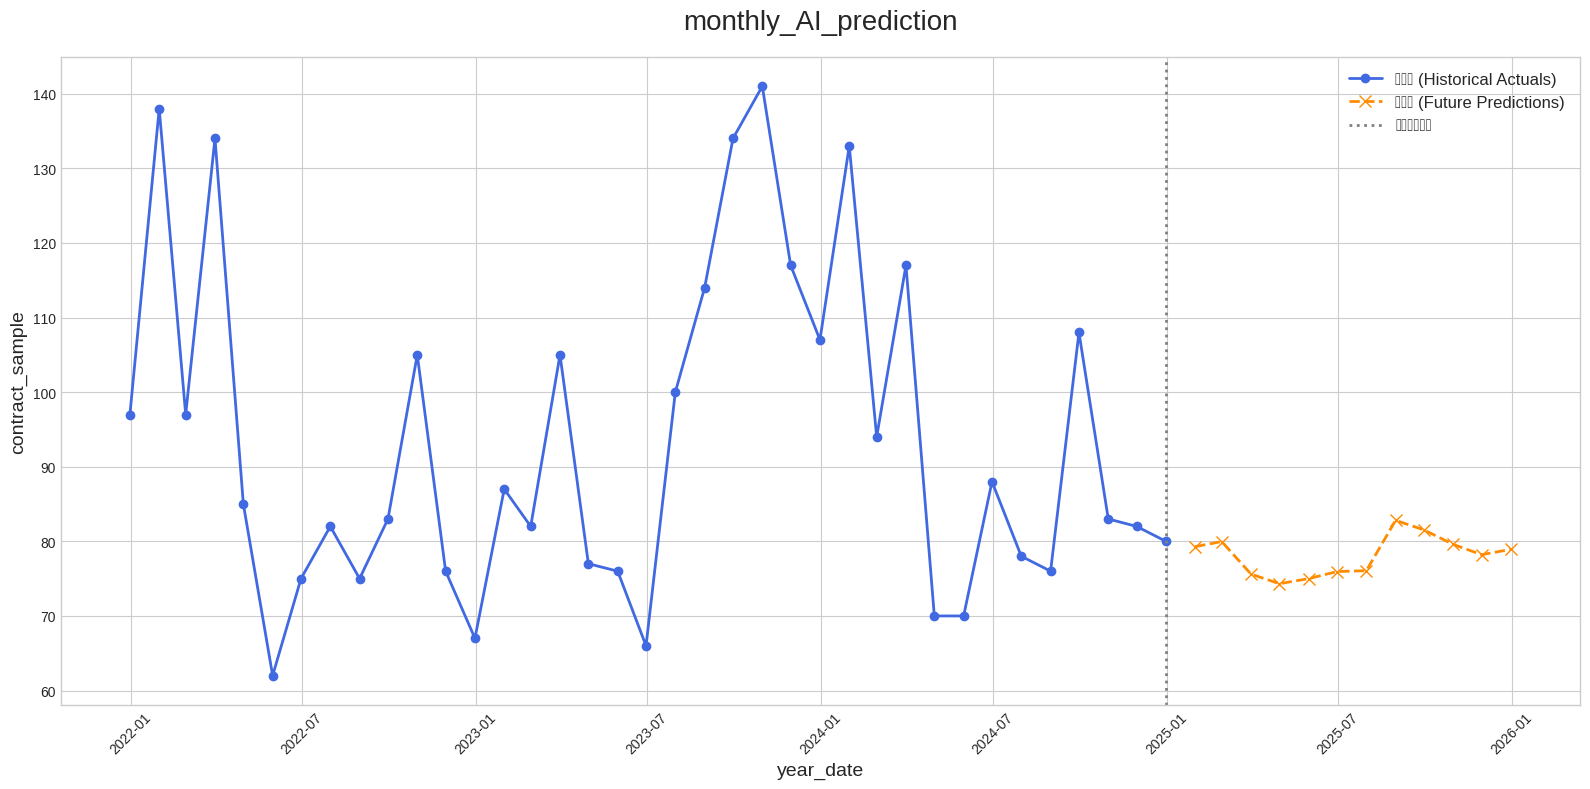

In [27]:
import matplotlib.font_manager as fm

font_path = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc' # for Mac
# font_path = 'C:/Windows/Fonts/YuGothM.ttc' # for Windows
try:
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()
    print(f"日本語フォント '{font_prop.get_name()}' を設定しました。")
except FileNotFoundError:
    print(f"警告: 指定されたフォントパス '{font_path}' が見つかりません。デフォルトフォントで描画します。")

dates = pd.date_range(start='2022-01-31', periods=37, freq='M')


# --- Step 1: 予測データに対応する未来の日付を作成 ---
last_historical_date = df_monthly.index[-1]
future_dates = pd.date_range(start=last_historical_date, periods=len(future_predictions) + 1, freq='M')[1:]

# --- Step 2: 予測値をPandas Seriesに変換 ---
future_predictions_series = pd.Series(future_predictions, index=future_dates)


# --- Step 3: グラフの描画 ---
plt.style.use('seaborn-v0_8-whitegrid') # グラフのスタイルを指定
plt.figure(figsize=(16, 8)) # グラフのサイズを大きく見やすく設定

# 3-a: 実績値のプロット
plt.plot(
    df_monthly.index,
    df_monthly['target_count_custom'],
    label='実績値 (Historical Actuals)',
    color='royalblue',
    marker='o',
    linewidth=2
)

# 3-b: 予測値のプロット
plt.plot(
    future_predictions_series.index,
    future_predictions_series.values,
    label='予測値 (Future Predictions)',
    color='darkorange',
    marker='x',
    linestyle='--',
    linewidth=2,
    markersize=8
)

# 3-c: 実績と予測の境界線に縦線を引く
plt.axvline(x=last_historical_date, color='gray', linestyle=':', linewidth=2, label='予測開始時点')


# --- Step 4: グラフの装飾 ---
plt.title('monthly_AI_prediction', fontsize=20, pad=20)
plt.xlabel('year_date', fontsize=14)
plt.ylabel('contract_sample', fontsize=14)
plt.xticks(rotation=45) # 日付ラベルを斜めにして見やすくする
plt.legend(fontsize=12) # 凡例を表示
plt.grid(True)
plt.tight_layout() # レイアウトを自動調整

plt.savefig("prediction.png", dpi=300, bbox_inches='tight')

# グラフを表示
plt.show()